In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, box
from scipy.spatial import cKDTree
from netCDF4 import Dataset
import xarray as xr
from shapely.ops import unary_union
from datetime import datetime, timedelta

In [2]:
def process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg):
    # Open the NetCDF-4 file
    nc = Dataset(nc_file_path, 'r')
    pixel_cloud = nc.groups['pixel_cloud']
    # Extract variables
    latitude = pixel_cloud.variables['latitude'][:]
    longitude = pixel_cloud.variables['longitude'][:]
    height = pixel_cloud.variables['height'][:]
    water_frac = pixel_cloud.variables['water_frac'][:]
    coherent_power = pixel_cloud.variables['coherent_power'][:]
    classification = pixel_cloud.variables['classification'][:]
    missed_detection_rate = pixel_cloud.variables['missed_detection_rate'][:]
    geolocation_qual = pixel_cloud.variables['geolocation_qual'][:]
    geoid_height_above_reference_ellipsoid = pixel_cloud.variables['geoid'][:]
    solid_earth_tide = pixel_cloud.variables['solid_earth_tide'][:]
    load_tide_fes = pixel_cloud.variables['load_tide_fes'][:]
    pole_tide = pixel_cloud.variables['pole_tide'][:]

    nc.close()
    # Create a pandas DataFrame
    df_PIXC = pd.DataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height - solid_earth_tide - load_tide_fes - pole_tide,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    })
    # Convert the DataFrame to an xarray Dataset
    ds = xr.Dataset.from_dataframe(df_PIXC)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(gnss_file_path)
    
    # Create the 'geometry' column using latitude and longitude values
    df['geometry'] = df.apply(lambda row: Point(row['longitude_decimal_degree'], row['latitude_decimal_degree']), axis=1)
    
    # Convert 'day_of_year', 'year', and 'decimal_hour' into a datetime format
    # Create a new 'Datetime' column
    def convert_to_datetime(row):
        # Calculate the date from 'day_of_year' and 'year'
        date = datetime(row['year'], 1, 1) + timedelta(days=row['day_of_year'] - 1)
        # Extract hours, minutes, and seconds from 'decimal_hour'
        hours = int(row['decimal_hour'])
        minutes = int((row['decimal_hour'] - hours) * 60)
        seconds = (row['decimal_hour'] - hours - minutes / 60) * 3600
        # Create the final datetime object
        return datetime(date.year, date.month, date.day, hours, minutes, int(seconds))
    
    df['Datetime'] = df.apply(convert_to_datetime, axis=1)
    
    # Create a GeoDataFrame from the DataFrame using the 'geometry' column
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    # Step 4: Create the 'river' GeoDataFrame and apply height correction
    # Subtract the specified value from the ellipsoidal height
    gdf['Height(m)'] = gdf['ellipsoidal_height_m'] - height_correction

    
    # Step 5: Create the 'river' GeoDataFrame with the desired columns
    river1 = gdf[['Datetime', 'geometry', 'Height(m)']] 

    if cutoff_time_1 is None and cutoff_time_2 is None:
        river = river1
    elif cutoff_time_1 is None:
        river = river1[river1['Datetime'] < cutoff_time_2]
    elif cutoff_time_2 is None:
        river = river1[river1['Datetime'] > cutoff_time_1]
    else:
        river = river1[(river1['Datetime'] > cutoff_time_1) & (river1['Datetime'] < cutoff_time_2)]
    river = river.set_crs(epsg=4326)
    
    river = river.iloc[::-1]
    river = river.to_crs(f"EPSG:{utm_epsg}").copy()
    
    petrohue_gdf = gpd.read_file(sword_shp_path)
    petrohue_gdf = petrohue_gdf.to_crs(river.crs)
    # Filter the GeoDataFrame for the specified reach_id
    petrohue_SWORD = petrohue_gdf[petrohue_gdf['reach_id'] == int(section_id)]
    # Step 2: Calculate the bounding box of the 'river' GeoDataFrame
    river_bbox = petrohue_SWORD.total_bounds  # Returns (minx, miny, maxx, maxy)
    # Convert bounding box to a GeoDataFrame
    bbox_geom = box(*river_bbox)
    bbox_gdf = gpd.GeoDataFrame(index=[0], crs=river.crs, geometry=[bbox_geom])
    # Reset index before clipping to preserve the original order
    river_reset = river.reset_index(drop=False)
    # Clip the river GeoDataFrame with the bounding box
    clipped_river = gpd.clip(river_reset, bbox_gdf)
    
    # Get the minimum and maximum index values of the clipped river
    min_index = clipped_river['index'].min()
    max_index = clipped_river['index'].max()

    # Select the rows from river that are within the min and max indices
    river = river.loc[max_index:min_index]
    
    def calculate_cumulative_distance(gdf):
        gdf['prev_geometry'] = gdf['geometry'].shift()
        gdf['distance_to_prev'] = gdf.apply(lambda row: row['geometry'].distance(row['prev_geometry']) if pd.notna(row['prev_geometry']) else 0, axis=1)
        gdf['cumulative_distance'] = gdf['distance_to_prev'].cumsum()
        return gdf
    river = calculate_cumulative_distance(river)
    river.reset_index(drop=True, inplace=True)
    # Smooth the river data such that there is only 1 point about every meter:
    # Step 1: Round the cumulative_distance to create a grouping key
    river['rounded_cumulative_distance'] = river['cumulative_distance'].round()
    
    # Step 2: Group by the rounded cumulative distance
    # We'll calculate the mean of other columns and the centroid of the geometries
    smoothed_gdf = river.groupby('rounded_cumulative_distance').agg({
        'Height(m)': 'mean',  # Replace 'column_to_smooth' with the column you want to smooth
        'cumulative_distance': 'mean',
        'geometry': lambda x: x.unary_union.centroid,  # Take the centroid of the geometries in the group
        'Datetime': lambda x: x.median(),
    }).reset_index()
    
    # Step 3: Create a new GeoDataFrame from the smoothed data
    river = gpd.GeoDataFrame(smoothed_gdf, geometry='geometry', crs=f"EPSG:{utm_epsg}")
    
    # Create a LineString from the subset
    river_line = LineString(river.geometry.tolist())
    
     # Create a GeoDataFrame for the simplified LineString
    river_line_gdf = gpd.GeoDataFrame(geometry=[river_line], crs=river.crs)
    
    # Create a buffer around the simplified LineString
    simplified_river_buffered = river_line_gdf.buffer(buffer_distance, cap_style = 'flat')
    simplified_river_buffered_gdf = gpd.GeoDataFrame(geometry=simplified_river_buffered, crs=river.crs)
    
    river_heights = river['Height(m)'].values
    river_cum_dis = river['cumulative_distance'].values
    # Convert 'ds' to GeoDataFrame and clip to buffer
    ds_gdf = gpd.GeoDataFrame({
        'latitude': latitude,
        'longitude': longitude,
        'height': height - solid_earth_tide - load_tide_fes - pole_tide,
        'water_frac': water_frac,
        'coherent_power': coherent_power,
        'classification': classification,
        'missed_detection_rate': missed_detection_rate,
        'geolocation_qual': geolocation_qual
    }, geometry=gpd.points_from_xy(df_PIXC['longitude'], df_PIXC['latitude']), crs="EPSG:4326")
    ds_gdf = ds_gdf.to_crs(f"EPSG:{utm_epsg}")
    ds_clipped = gpd.sjoin(ds_gdf, simplified_river_buffered_gdf, how='inner', predicate='within')
    # Find nearest river point to each ds point
    ds_coords_utm = np.column_stack((ds_clipped.geometry.x, ds_clipped.geometry.y))
    river_coords_utm = np.column_stack((river.geometry.x, river.geometry.y))
    
    tree_river = cKDTree(river_coords_utm)
    distances, indices = tree_river.query(ds_coords_utm)
    nearest_GNSS_height = river_heights[indices]
    nearest_GNSS_dist = river_cum_dis[indices]
    ds_clipped['nearest_GNSS_height'] = nearest_GNSS_height
    ds_clipped['nearest_GNSS_dist'] = nearest_GNSS_dist
    ds_clipped['nearest_index'] = indices
    ds_clipped['distance_to_nearest'] = distances
    # Merge DataFrames
    columns_to_keep = [col for col in ds_clipped.columns if col not in river.columns or col == 'nearest_index']
    ds_clipped_subset = ds_clipped[columns_to_keep]
    merged_df = river.merge(ds_clipped_subset, left_index=True, right_on='nearest_index', how='left')

    # These next rows will eliminate rows where there are multiple SWOT points for a GNSS point and keep the nearest.
    # Find the counts of each unique value in the 'Height(m)' column
    height_counts = merged_df['cumulative_distance'].value_counts()
    
    # Identify duplicate heights (those that occur more than once)
    duplicate_heights = height_counts[height_counts > 1].index
    
    # Filter rows with duplicate heights
    duplicate_rows = merged_df[merged_df['cumulative_distance'].isin(duplicate_heights)]
    
    # Group by 'Height(m)' and find the row with the minimum 'distance_to_nearest' for each group
    filtered_duplicates = duplicate_rows.loc[duplicate_rows.groupby('cumulative_distance')['distance_to_nearest'].idxmin()]
    
    # Filter rows with unique heights (those that occur only once)
    unique_rows = merged_df[~merged_df['cumulative_distance'].isin(duplicate_heights)]
    
    # Combine the unique rows with the filtered duplicates
    final_result = pd.concat([unique_rows, filtered_duplicates])

    #print(merged_df.head())
    # Save the combined DataFrame to a CSV file
    final_result.to_csv(output_file_path, index=False)

In [5]:
def apply_filter(df):
    return df[(df['classification'] > 2) & (df['classification'] !=5)].copy()

In [42]:
# Example usage:
section_id = '66190600041'
nc_file_path = 'data/2023-12-30/SWOT_L2_HR_PIXC_008_451_082R_20231230T085406_20231230T085417_PIC0_01.nc'
gnss_file_path = "data/2023-12-30/SEPT3640.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2023-12-30 08:55:53.0000000000')
cutoff_time_2 = pd.to_datetime('2023-12-30 9:35:30.0000000000')
height_correction = .9283 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

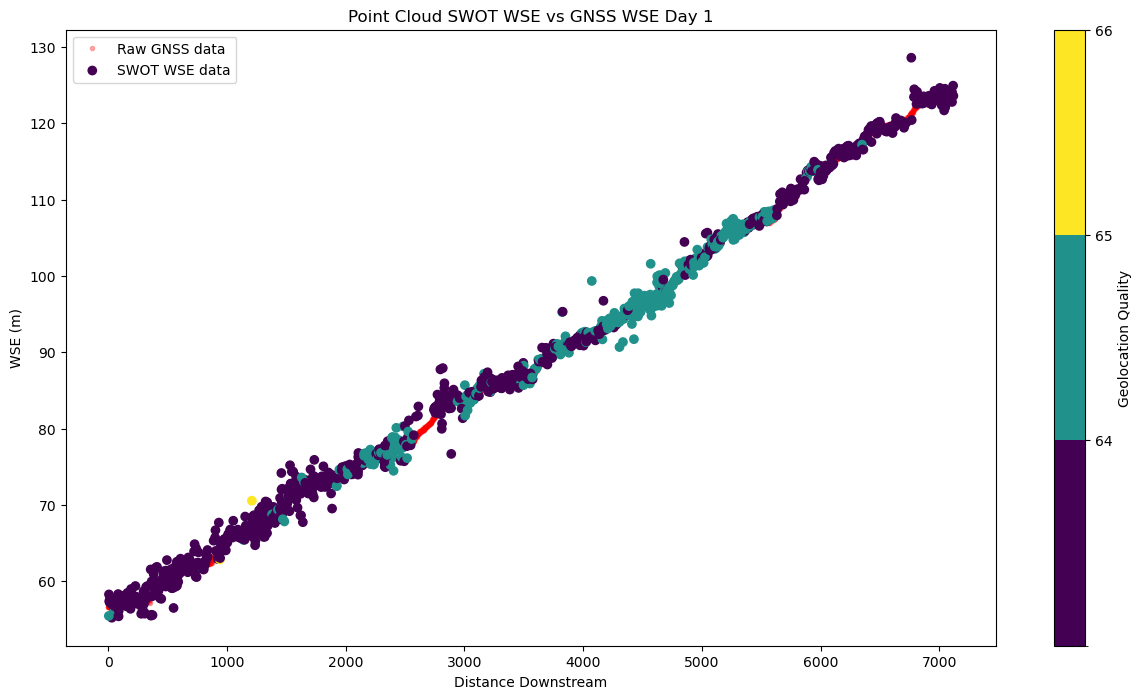

In [43]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()

In [44]:
# Example usage:
section_id = '66190600041'
date = '20240131'
nc_file_path = 'data/2023-12-30/SWOT_L2_HR_PIXC_010_188_227L_20240131T171749_20240131T171800_PIC0_01.nc'
gnss_file_path = "data/2023-12-30/SEPT3640.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2023-12-30 08:55:53.0000000000')
cutoff_time_2 = pd.to_datetime('2023-12-30 9:35:30.0000000000')
height_correction = .9283 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_{date}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

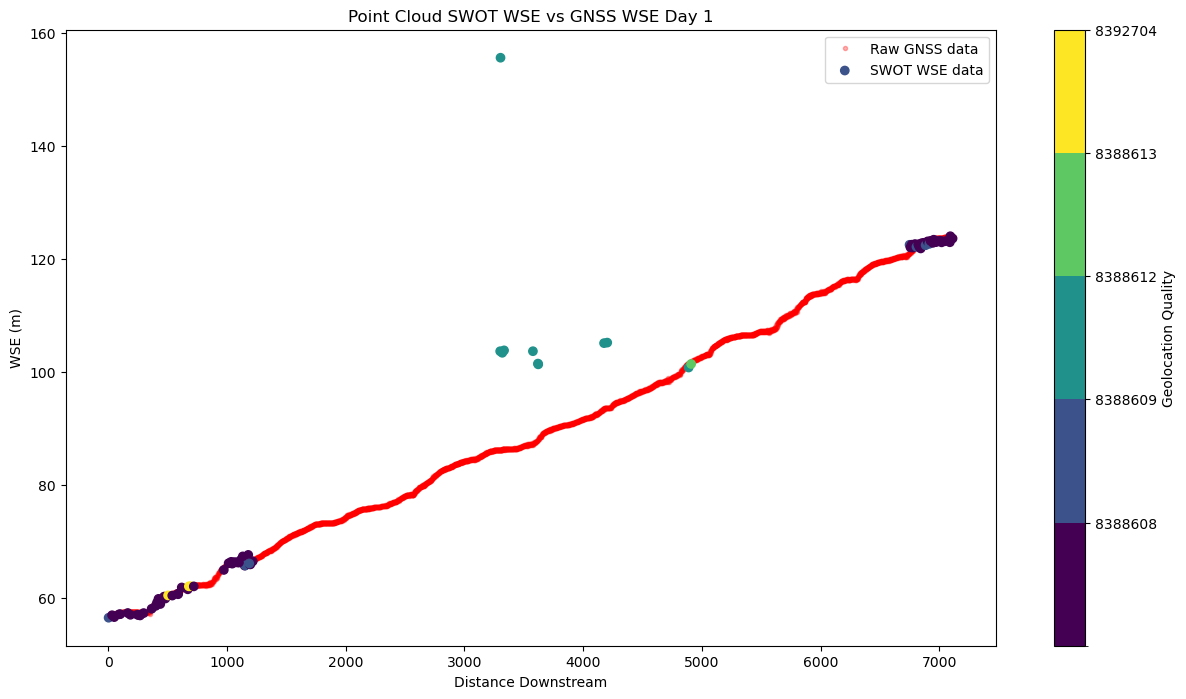

In [45]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()

In [46]:
# Example usage:
section_id = '66190600023'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_009_145_082L_20240109T071622_20240109T071634_PIC0_01.nc'
gnss_file_path = "data/2024-01-09/SEPT0092.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

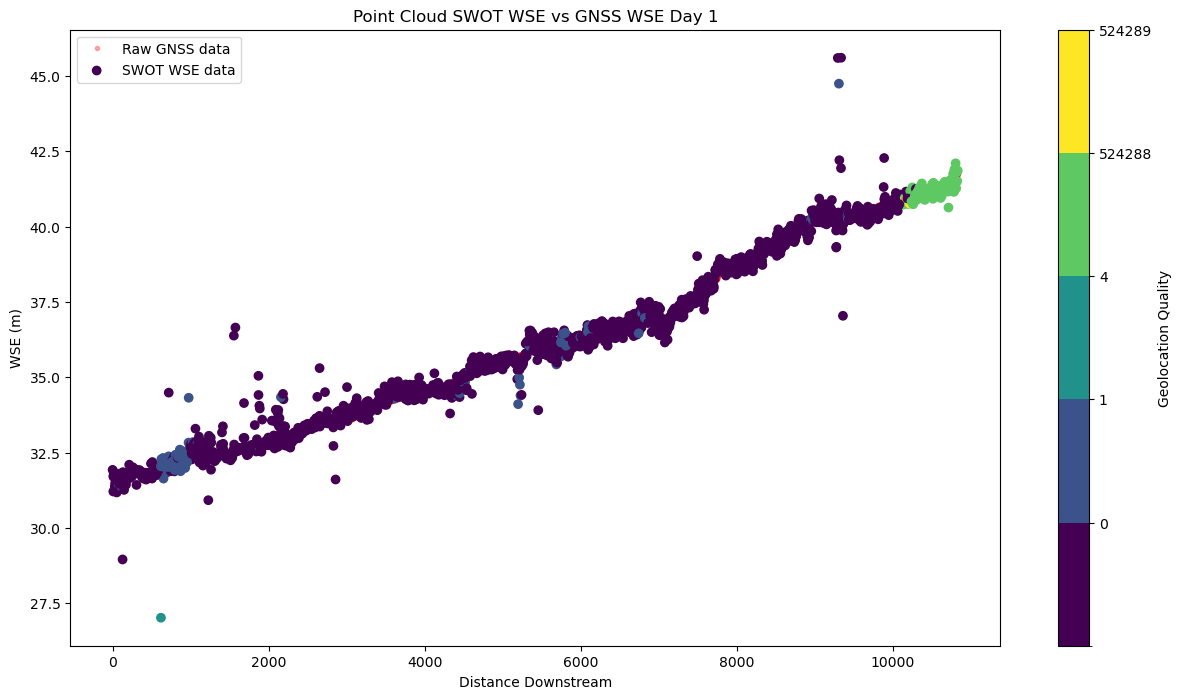

In [47]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()

In [48]:
# Example usage:
section_id = '66190600033'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_009_145_082L_20240109T071622_20240109T071634_PIC0_01.nc'
gnss_file_path = "data/2024-01-09/SEPT0092.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

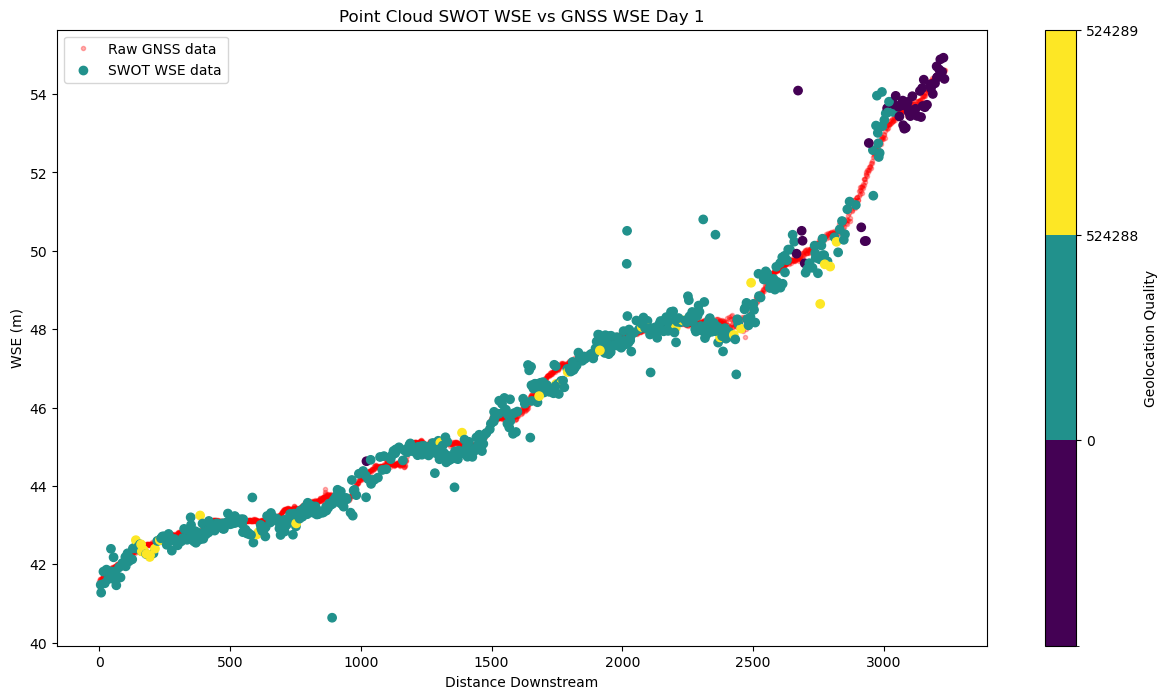

In [49]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()

In [50]:
# Example usage:
section_id = '66190600023'
date = '20240131'
nc_file_path = 'data/2024-01-09/SWOT_L2_HR_PIXC_010_188_227L_20240131T171749_20240131T171800_PIC0_01.nc'
gnss_file_path = "data/2024-01-09/SEPT0092.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = pd.to_datetime('2024-01-09 05:25:52.0000000000')
cutoff_time_2 = None
height_correction = 1.148 #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_{date}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

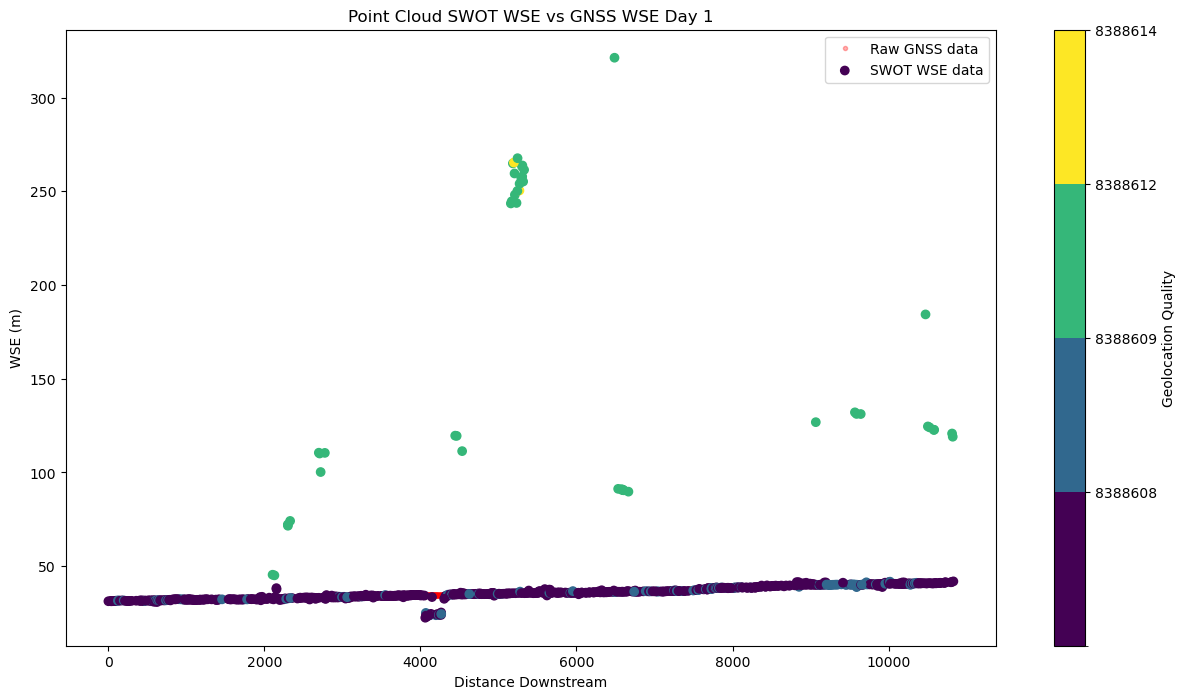

In [51]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()

In [52]:
# Example usage:
section_id = '66190600011'
nc_file_path = 'data/2024-01-10/SWOT_L2_HR_PIXC_009_188_227L_20240110T203243_20240110T203254_PIC0_01.nc'
gnss_file_path = "data/2024-01-10/SEPT0100.csv"
sword_shp_path = 'data/petrohue_SWORD_reach/petrohue_v16.shp'
cutoff_time_1 = None
cutoff_time_2 = pd.to_datetime('2024-01-10 22:51:11.0000000000')
height_correction = 1.134  #This is the antenna height
output_file_path = f'data/SWOT_GNSS_processed_csvs/buffered_{section_id}_GNSS_SWOT_cumulative_dist_height.csv'
buffer_distance = 50
utm_epsg = 32718
#process_data(section_id, nc_file_path, gnss_file_path, sword_shp_path, cutoff_time_1, cutoff_time_2, height_correction, output_file_path, buffer_distance, utm_epsg)

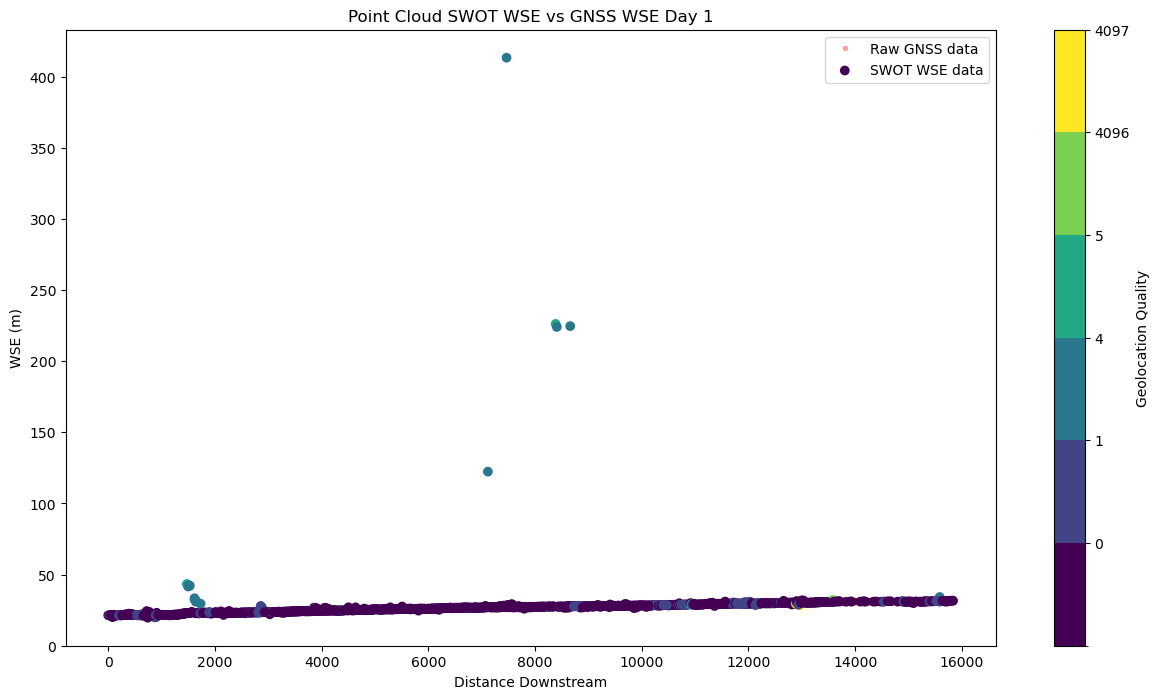

In [53]:
# Load and filter data
data = pd.read_csv(output_file_path)
df_filtered = apply_filter(data)

# Ensure 'geolocation_qual' is numeric
df_filtered['geolocation_qual'] = pd.to_numeric(df_filtered['geolocation_qual'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['geolocation_qual'])

# Map unique geolocation_qual values to integers
unique_vals = np.sort(df_filtered['geolocation_qual'].unique())
n_colors = len(unique_vals)
val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
df_filtered['geolocation_qual_int'] = df_filtered['geolocation_qual'].map(val_to_int)

# Create colormap and norm
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_colors)))
boundaries = np.linspace(-0.5, n_colors - 0.5, n_colors + 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    data.cumulative_distance,
    data['Height(m)'],
    'ro',
    markersize=3,
    alpha=0.3,
    label='Raw GNSS data'
)

sc = ax.scatter(
    df_filtered.nearest_GNSS_dist,
    df_filtered['height'],
    c=df_filtered['geolocation_qual_int'],
    cmap=cmap,
    norm=norm,
    zorder=2,
    label='SWOT WSE data'
)

# Add legend, titles, and labels
ax.legend()
ax.set_title('Point Cloud SWOT WSE vs GNSS WSE Day 1')
ax.set_xlabel('Distance Downstream')
ax.set_ylabel('WSE (m)')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, boundaries=boundaries, spacing='uniform')
cbar.set_label('Geolocation Quality')

# Set ticks at the center of each color segment
tick_locs = np.arange(n_colors) + 0.5
cbar.set_ticks(tick_locs)

# Set tick labels to the original geolocation_qual values
tick_labels = unique_vals.astype(int)
cbar.set_ticklabels(tick_labels)

plt.show()